This notebook imports the clustering_results.pkl dataframe and uses it to generates some images from the paper.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import itertools

import sys
sys.path.append('..')
from Clustering_Functions import *

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [20]:
df = pd.read_pickle('../clustering_results.pkl')

In [21]:
print(df.columns)
print(df['method'].unique())

Index(['filename', 'num_cands', 'parties', 'method', 'sil', 'cal', 'dav',
       'centers', 'bloc size'],
      dtype='object')
['Lloyd_Bp' 'Lloyd_Ba' 'Lloyd_H' 'PAM_Bp' 'PAM_Ba' 'PAM_H' 'slate']


There is one row for each election+method pair.

the methods are: 'meanBC' = Lloyd's 2-means with Borda pessimistic, 'medoBA' = PAM 2-medoid with Borda average, etc.

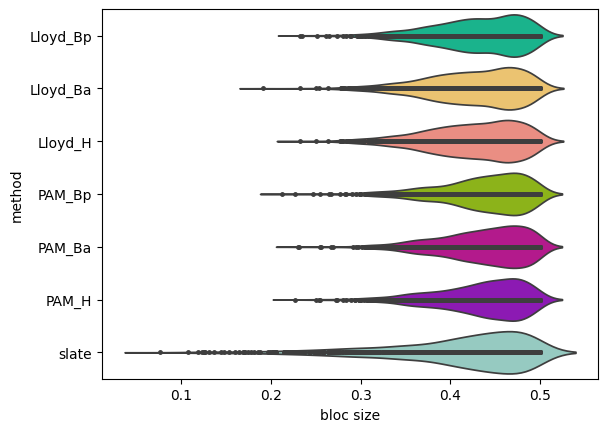

In [45]:
palat = {'Lloyd_Bp': '#00CD99', 'Lloyd_Ba': '#FFCA5D', 'Lloyd_H': '#FB8072',
         'PAM_Bp': '#99CD00', 'PAM_Ba': '#CD0099', 'PAM_H': '#9900CD',
         'slate': '#8DD3C7'}
fig = sns.violinplot(data = df, x = 'bloc size', y='method', hue='method', inner='point', 
                     palette = palat)
fig.figure.savefig('bloc_size.png', dpi=150, bbox_inches='tight')

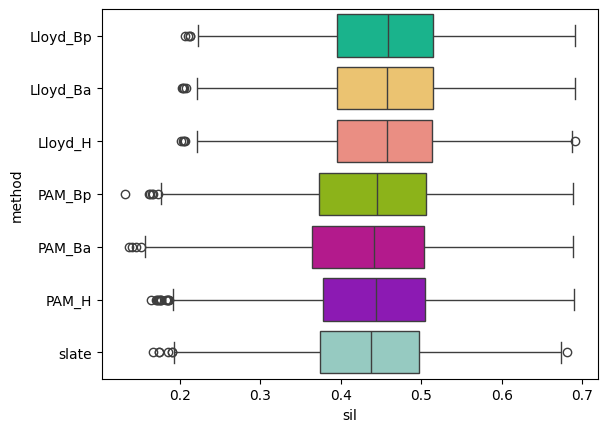

In [24]:
fig = sns.boxplot(data=df, x='sil',y='method', hue = 'method', 
                     palette = palat)
# fig.figure.savefig("sil.png", dpi = 150, bbox_inches = 'tight')

Only the centers are stored, but the full clusterings can be recovered using `Clusters_from_centers` as follows (this takes a few minutes).

In [37]:
D = {'Lloyd_Bp': ('Borda','pes',True), 'Lloyd_Ba': ('Borda','avg',True), 'Lloyd_H':('HH',None,True),
     'PAM_Bp': ('Borda','pes',False), 'PAM_Ba':('Borda','avg',False), 'PAM_H': ('HH',None,False), 
     'slate': (None,None,None)}

clustering_list = []

for index in df.index:
    method = df['method'][index]
    filename = df['filename'][index]
    num_cands = df['num_cands'][index]
    centers = df['centers'][index]
    centers = [centers[i] for i in range(len(centers))] #convert dict to list

    full_filename = f'../scot-elex/{num_cands}_cands/{filename}'
    _, election, __, ___ = csv_parse(full_filename)
    proxy, borda_style, centers_live_in_proxy_space = D[method]
    if method =='slate':
        C = Slate_cluster(election, slates = centers)
    else:
        order = 2 if centers_live_in_proxy_space else 1 # only use 2 for Lloyd.
        _,C = Clusters_from_centers(election, centers, proxy, borda_style, order, centers_live_in_proxy_space)
    clustering_list.append(C)
df['clustering'] = clustering_list

Measure the average (and maximum) over the elections of the closeness of each pair of methods and create an MDS plot of the result

In [38]:
method_list = df['method'].unique()
full_filename_list = glob.glob("../scot-elex/**/*.csv")
filename_list = [os.path.basename(x) for x in full_filename_list]

election_to_closssness = dict() # dictionary mapping the election filename to a dictionary mapping method pairs to closeness

for full_filename in full_filename_list:
    num_cands, election, cand_names, location = csv_parse(full_filename)
    filename = os.path.basename(full_filename)
    # print(filename)

    # create dictionary mapping method to clustering
    method_pair_to_clustering = dict()
    for method in method_list:
        method_pair_to_clustering[method] = df[(df['filename'] == filename) & (df['method'] == method)]['clustering'].values[0]

    # create dictionary mapping method pair to closeness
    pair_to_closeness = dict()
    for m1, m2 in itertools.combinations(method_list,2):
        C1 = method_pair_to_clustering[m1]
        C2 = method_pair_to_clustering[m2]
        pair_to_closeness[(m1,m2)] = Clustering_closeness(election,C1,C2) 

    election_to_closssness[filename] = pair_to_closeness

# make dataframe of average (and maximum) closeness of each pair of methods
avg_closeness = pd.DataFrame(columns=method_list, index=method_list)
max_closeness = pd.DataFrame(columns=method_list, index=method_list)
for m1, m2 in itertools.combinations(method_list, 2):
    avg_closeness.loc[m1,m2] = np.mean([election_to_closssness[filename][(m1,m2)] for filename in filename_list])
    max_closeness.loc[m1,m2] = np.max([election_to_closssness[filename][(m1,m2)] for filename in filename_list])

# make it into a skey symmetric matrix
for m1, m2 in itertools.product(method_list, method_list):
    if m1 == m2:
        avg_closeness.loc[m1,m2] = 0
        max_closeness.loc[m1,m2] = 0
    if pd.isna(avg_closeness.loc[m1,m2]):
        avg_closeness.loc[m1,m2] = avg_closeness.loc[m2,m1]
    if pd.isna(max_closeness.loc[m1,m2]):
        max_closeness.loc[m1,m2] = max_closeness.loc[m2,m1]

avg_closeness

,Lloyd_Bp,Lloyd_Ba,Lloyd_H,PAM_Bp,PAM_Ba,PAM_H,slate
Lloyd_Bp,0,0.015595,0.017808,0.071109,0.085867,0.069813,0.090398
Lloyd_Ba,0.015595,0,0.014123,0.07223,0.083655,0.069904,0.092952
Lloyd_H,0.017808,0.014123,0,0.069477,0.082135,0.067336,0.086232
PAM_Bp,0.071109,0.07223,0.069477,0,0.067121,0.0444,0.123986
PAM_Ba,0.085867,0.083655,0.082135,0.067121,0,0.078688,0.151636
PAM_H,0.069813,0.069904,0.067336,0.0444,0.078688,0,0.124609
slate,0.090398,0.092952,0.086232,0.123986,0.151636,0.124609,0


In [39]:
max_closeness

,Lloyd_Bp,Lloyd_Ba,Lloyd_H,PAM_Bp,PAM_Ba,PAM_H,slate
Lloyd_Bp,0,0.416978,0.416033,0.49806,0.499256,0.494565,0.463225
Lloyd_Ba,0.416978,0,0.395522,0.497214,0.4937,0.49689,0.461103
Lloyd_H,0.416033,0.395522,0,0.494179,0.490947,0.498272,0.462518
PAM_Bp,0.49806,0.497214,0.494179,0,0.533012,0.531528,0.554619
PAM_Ba,0.499256,0.4937,0.490947,0.533012,0,0.576662,0.629146
PAM_H,0.494565,0.49689,0.498272,0.531528,0.576662,0,0.58971
slate,0.463225,0.461103,0.462518,0.554619,0.629146,0.58971,0


c:\Users\ktapp\Documents\Python\ballot-clustering\.venv\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


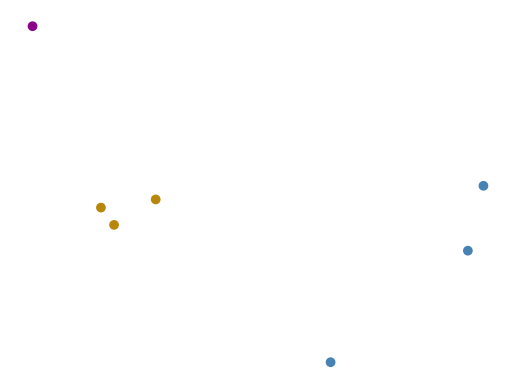

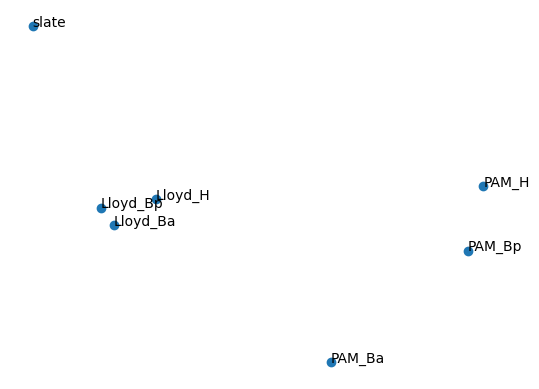

In [44]:
# Create MDS plot of the distances between the methods
# The lables are left off one image, so it can be labeled by hand.
projections = MDS(n_components=2, dissimilarity='precomputed').fit_transform(avg_closeness)
X = np.array([p[0] for p in projections])
Y = np.array([p[1] for p in projections])

fig, ax = plt.subplots()
ax.scatter(X,Y, c = ['darkgoldenrod','darkgoldenrod','darkgoldenrod','steelblue','steelblue','steelblue','darkmagenta'])
ax.grid(False)
ax.axis('off')
plt.savefig("method_MDS_unlabled", dpi = 600)
plt.show()

fig, ax = plt.subplots()
ax.scatter(X,Y)
for count in range(len(method_list)):
    ax.annotate(method_list[count], xy=(X[count], Y[count]))
ax.grid(False)
ax.axis('off')
#plt.savefig("plots/method_MDS_labeled", dpi = 600)
plt.show()

Next we'll study some demographic questions that are unrelated to clustering.

We'll start by reducing to a dataframe with only one row per election

In [ ]:
d0 = df[df['method']=='slate'][['filename', 'num_cands', 'parties']].copy()

,filename,num_cands,parties
6,aberdeen_2017_ward12.csv,10,"{1: 'Lab', 2: 'SNP', 3: 'Con', 4: 'Ind', 5: 'S..."
14,aberdeen_2022_ward12.csv,10,"{1: 'API', 2: 'SNP', 3: 'Ind', 4: 'SNP', 5: 'G..."
22,aberdeen_2022_ward6.csv,10,"{1: 'Con', 2: 'LD', 3: 'SFP', 4: 'Lab', 5: 'Gr..."
30,aberdeenshire_2012_ward18.csv,10,"{1: 'Con', 2: 'LD', 3: 'Lab', 4: 'SNP', 5: 'SN..."
38,aberdeenshire_2012_ward3.csv,10,"{1: 'LD', 2: 'SNP', 3: 'Ind', 4: 'Ind', 5: 'SN..."
...,...,...,...
8526,west_dunbartonshire_2022_ward3.csv,9,"{1: 'SNP', 2: 'Lab', 3: 'Lab', 4: 'TUSC', 5: '..."
8534,west_lothian_2012_ward8.csv,9,"{1: 'Ind', 2: 'SNP', 3: 'Lab', 4: 'Ind', 5: 'U..."
8542,west_lothian_2017_ward2.csv,9,"{1: 'SNP', 2: 'SNP', 3: 'Lab', 4: 'Gr', 5: 'Co..."
8550,west_lothian_2017_ward8.csv,9,"{1: 'SNP', 2: 'SNP', 3: 'Lab', 4: 'Con', 5: 'S..."


In [70]:
# add columns 'year','location', 'ward' from the separate parts of the filename

def parse_filename(filename):
    # Split the filename and remove the '.csv' extension
    parts = filename[:-4].split('_')
    
    # Find the year, which is a 4-digit number
    for i, part in enumerate(parts):
        if part.isdigit() and len(part) == 4:
            year_index = i
            break
    else:
        return None  # Return None if no 4-digit year is found

    # Join parts before the year as location and parts after the year as sublocation
    location = ' '.join(parts[:year_index])
    year = int(parts[year_index])
    sublocation = ' '.join(parts[year_index + 1:])
    
    return location, year, sublocation

ls_location = []
ls_year = []
ls_ward = []
for index in d0.index:
    location, year, ward = parse_filename(d0['filename'][index])
    ls_location.append(location)
    ls_year.append(year)
    ls_ward.append(ward)
d0['location'] = ls_location
d0['year'] = ls_year
d0['ward'] = ls_ward

In [71]:
d0

,filename,num_cands,parties,location,year,ward
6,aberdeen_2017_ward12.csv,10,"{1: 'Lab', 2: 'SNP', 3: 'Con', 4: 'Ind', 5: 'S...",aberdeen,2017,ward12
14,aberdeen_2022_ward12.csv,10,"{1: 'API', 2: 'SNP', 3: 'Ind', 4: 'SNP', 5: 'G...",aberdeen,2022,ward12
22,aberdeen_2022_ward6.csv,10,"{1: 'Con', 2: 'LD', 3: 'SFP', 4: 'Lab', 5: 'Gr...",aberdeen,2022,ward6
30,aberdeenshire_2012_ward18.csv,10,"{1: 'Con', 2: 'LD', 3: 'Lab', 4: 'SNP', 5: 'SN...",aberdeenshire,2012,ward18
38,aberdeenshire_2012_ward3.csv,10,"{1: 'LD', 2: 'SNP', 3: 'Ind', 4: 'Ind', 5: 'SN...",aberdeenshire,2012,ward3
...,...,...,...,...,...,...
8526,west_dunbartonshire_2022_ward3.csv,9,"{1: 'SNP', 2: 'Lab', 3: 'Lab', 4: 'TUSC', 5: '...",west dunbartonshire,2022,ward3
8534,west_lothian_2012_ward8.csv,9,"{1: 'Ind', 2: 'SNP', 3: 'Lab', 4: 'Ind', 5: 'U...",west lothian,2012,ward8
8542,west_lothian_2017_ward2.csv,9,"{1: 'SNP', 2: 'SNP', 3: 'Lab', 4: 'Gr', 5: 'Co...",west lothian,2017,ward2
8550,west_lothian_2017_ward8.csv,9,"{1: 'SNP', 2: 'SNP', 3: 'Lab', 4: 'Con', 5: 'S...",west lothian,2017,ward8


In [ ]:
d0['location'].unique()  # The 32 "Council Areas", also called "Local Authority Areas"

array(['aberdeen', 'aberdeenshire', 'angus', 'argyll bute', 'dumgal',
       'dundee', 'east renfrewshire', 'edinburgh', 'eilean siar',
       'falkirk', 'fife', 'glasgow', 'highland', 'moray',
       'north ayrshire', 'north lanarkshire', 'renfrewshire',
       'south lanarkshire', 'stirling', 'west lothian', 'orkney',
       'clackmannanshire', 'east ayrshire', 'east dunbartonshire',
       'midlothian', 'sc borders', 'shetland', 'south ayrshire',
       'east lothian', 'inverclyde', 'perth kinross',
       'west dunbartonshire'], dtype=object)

In [76]:
d0['year'].value_counts()

2012    353
2017    351
2022    345
2007     21
Name: year, dtype: int64

In [77]:
# gather the set of all parties in all elections
set_of_all_parties = set()
for index in d0.index:
    set_of_all_parties = set_of_all_parties.union(set(d0['parties'][index].values()))

# create a dictionary matching party codes to the portion of total Borda points
# received by all candidates from that party in all elections.
party_to_borda={code:0 for code in set_of_all_parties}
filename_list = glob.glob("../scot-elex/**/*.csv")

for filename in filename_list:
    num_cands, election, cand_names, location = csv_parse(filename)
    party_list = party_abrevs(cand_names)
    for ballot, weight in election.items():
        for position in range(len(ballot)):
            party = party_list[ballot[position]-1]
            party_to_borda[party] += weight*(num_cands-position-1)

# scale the values to become percentage of all Borda points
total_weight = sum(party_to_borda.values())
for code, weight in party_to_borda.items():
    party_to_borda[code] = 100*weight/total_weight

# print the parties sorted by total Borda weight
def print_sorted(input_dict):
    # Sort the dictionary by values
    sorted_items = sorted(input_dict.items(), key=lambda item: item[1], reverse=True)
    
    # Print the sorted dictionary
    for key, value in sorted_items:
        print(f"{key}: {value}")

print_sorted(party_to_borda)

SNP: 28.74765729404872
Lab: 23.95570444169389
Con: 13.50953205501675
Ind: 11.73632225338278
LD: 9.697650822488496
Gr: 7.249022670196341
LabCo: 0.9456701075769515
API: 0.563822752349618
Soc: 0.5533707283015901
Sol: 0.4491702130287654
UKIP: 0.39472722068880634
SFP: 0.3624418752798889
TUSC: 0.3587408834899952
Glasgow First: 0.17097708000396458
SU: 0.1471126985122634
Libtn: 0.1456049296382576
SLP: 0.0970089982864339
SSC: 0.09473756920469367
SC: 0.08901011764668539
IANL: 0.07417049767620729
WDuns: 0.06980360338589454
ISP: 0.06901234100197694
Borders: 0.06755172584561739
Lib: 0.041804645920088986
FA: 0.036243957509854034
WEP: 0.032968499269450904
NRMUPB: 0.03142162731251895
SDP: 0.027334205056060826
CICA: 0.02703633157141742
BNP: 0.025651622399561605
EDIA: 0.023974790196433875
Rubbish: 0.02321918062341953
Volt: 0.018774080167254466
EKA: 0.018453204869125085
Pir: 0.016772922393974463
CPA: 0.01608516817074375
NF: 0.015609030631584024
Comm: 0.013730932560453999
OMG: 0.013239843842528388
Sov: 0.

Text(0.5, 1.0, 'Portion of total Borda points')

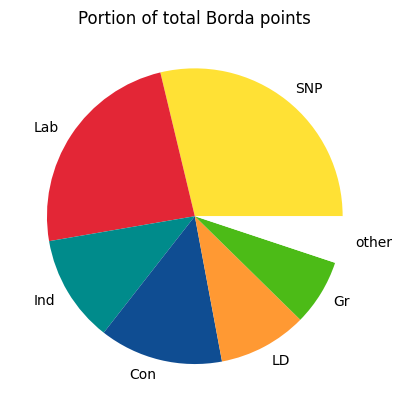

In [78]:
# make a pie chart of the Borda points of the top parties

top_parties = ['SNP', 'Lab', 'Ind', 'Con', 'LD', 'Gr']
scores = [party_to_borda[code] for code in top_parties]
top_parties.append('other')
scores.append(sum(x for x in party_to_borda.values() if x<=1))

D = {'SNP':'#FFE135', 'Lab': '#E32636', 'Con':'#0F4D92','LD':'#FF9933','Gr':'#4CBB17', 'Ind': '#008B8B', 'other':'white'}
colors = [D[party] for party in top_parties]

plt.pie(scores, labels = top_parties, colors=colors)
plt.title('Portion of total Borda points')
#plt.savefig("plots/pie.jpg")